In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='150GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)
client

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44945 instead
  warnings.warn(


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=140G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.166:43498 --nthreads 36 --memory-limit 139.70GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.166:43498,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [6]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":10},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

ds = read_CM4X(datadir("CM4Xp25_historical_transient_tracers.zarr"))
ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})
ds = approximate_z(ds)
# ds = ds.where(ds.thkcello > 1e-9)
ds
# # 
#need to interpolate zl to z next 

<xarray.Dataset>
Dimensions:    (yh: 540, xh: 720, year: 165, zl: 75)
Coordinates:
    areacello  (yh, xh) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    deptho     (yh, xh) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    lat        (yh, xh) float64 dask.array<chunksize=(540, 720), meta=np.ndarray>
    lon        (yh, xh) float64 dask.array<chunksize=(540, 720), meta=np.ndarray>
    wet        (yh, xh) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
  * xh         (xh) float64 -299.6 -299.1 -298.6 -298.1 ... 58.91 59.41 59.9
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * yh         (yh) float64 -80.35 -80.19 -80.02 -79.86 ... 89.46 89.68 89.89
  * zl         (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Data variables:
    cfc11      (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    cfc12      (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    sf6        (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    so         (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    thetao     (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    thkcello   (year, zl, yh, xh) float32 dask.array<chunksize=(10, 75, 540, 720), meta=np.ndarray>
    z          (year, yh, xh, zl) float32 dask.array<chunksize=(10, 540, 720, 1), meta=np.ndarray>

In [7]:
ds_locs = xr.Dataset()
ds_locs["lon"] = xr.DataArray(
    data=np.arange(-299, 59), dims=("locations") #need to regrid within model coordinates
)
ds_locs["lat"] = xr.DataArray(data=np.repeat(-50, len(ds_locs["lon"])), dims=("locations"))

In [8]:
regridder = xe.Regridder(ds, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True, periodic = False)
section_dsm = regridder(ds).compute()

In [9]:
section_dsm["lon"] = ("locations", ds_locs["lon"].values)
section_dsm["lat"] = ("locations", ds_locs["lat"].values)

In [10]:
section_dsm = get_sigma2(section_dsm).compute()

In [21]:
new_sigma_grid = np.linspace(section_dsm.sigma2.min(), section_dsm.sigma2.max())

In [22]:
new_sigma_grid

array([34.40383268, 34.46165098, 34.51946928, 34.57728758, 34.63510588,
       34.69292418, 34.75074248, 34.80856078, 34.86637908, 34.92419738,
       34.98201568, 35.03983398, 35.09765228, 35.15547058, 35.21328888,
       35.27110718, 35.32892548, 35.38674378, 35.44456208, 35.50238038,
       35.56019868, 35.61801697, 35.67583527, 35.73365357, 35.79147187,
       35.84929017, 35.90710847, 35.96492677, 36.02274507, 36.08056337,
       36.13838167, 36.19619997, 36.25401827, 36.31183657, 36.36965487,
       36.42747317, 36.48529147, 36.54310977, 36.60092807, 36.65874637,
       36.71656467, 36.77438297, 36.83220127, 36.89001957, 36.94783787,
       37.00565617, 37.06347447, 37.12129277, 37.17911107, 37.23692937])

In [12]:
ds_sections = []
for i in range(len(section_dsm.year)):
    if (i %20) == 0:
        print(i)
    tmp =  1* interpolate_section(section_dsm[["cfc11", "cfc12", "sf6", "sigma2", "thkcello", "z", "thetao"]].isel(year = i).compute(),
                                 new_sigma_grid, 
                                interp_coord = "sigma2",iterate_coord =  "locations", kind = "linear")
    ds_sections = ds_sections + [tmp]

ds_section = xr.concat(ds_sections, dim = "year")

0
20
40
60
80
100
120
140
160


In [13]:
ds_section["year"] = section_dsm.year

[None, None, None]

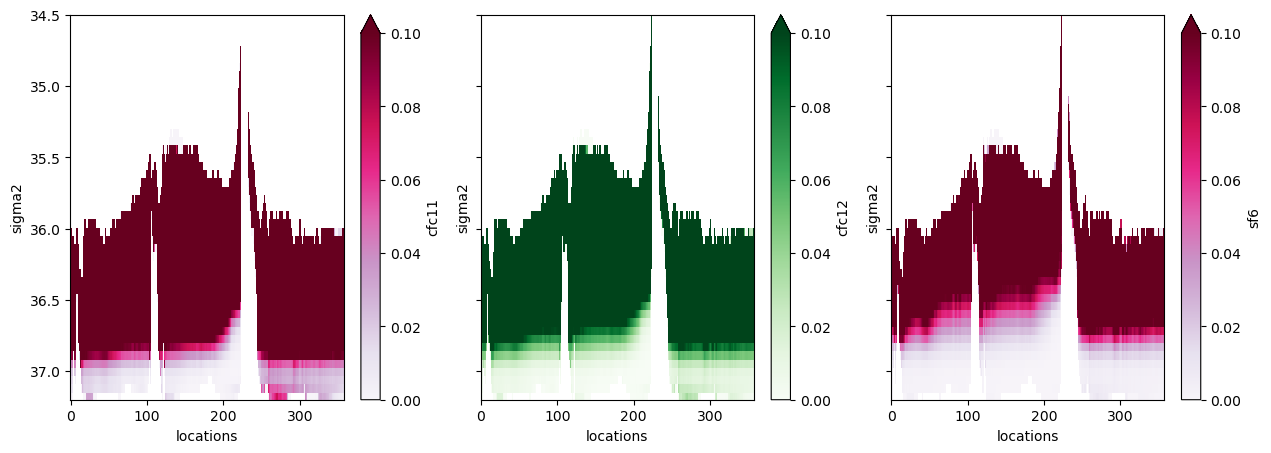

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)


(ds_section.cfc11.mean("year") * variable_kwargs["cfc11"]["conversion"]).plot(vmin = 0, vmax  = .1, ax = ax[0], cmap = variable_kwargs["cfc11"]["cmap"])
(ds_section.cfc12.mean("year") * variable_kwargs["cfc12"]["conversion"]).plot(vmin = 0, vmax  = .1, ax = ax[1], cmap = variable_kwargs["cfc12"]["cmap"])
(ds_section.sf6.mean("year") * variable_kwargs["sf6"]["conversion"]).plot(vmin = 0, vmax  =.1, ax = ax[2], cmap = variable_kwargs["sf6"]["cmap"])
[a.set_ylim(34.5, 37.2) for a in ax]
[a.invert_yaxis() for a in ax]


In [15]:
weighted_mean_ds = (ds_section * ds_section.thkcello).sum("locations") / ds_section.thkcello.sum("locations")
weighted_mean_ds["year"]= section_dsm.year

In [16]:
def derivative(ds):
    return ds.values[1:, :] - ds.values[:-1, :]

[None, None, None]

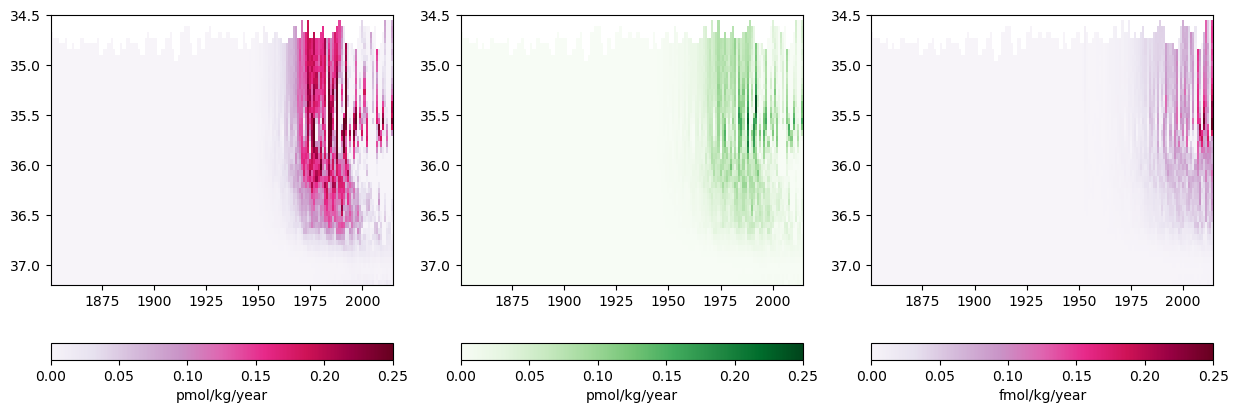

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.cfc11).T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg/year")

cm = ax[1].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.cfc12).T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg/year")

cm = ax[2].pcolormesh(weighted_mean_ds.year[1:], weighted_mean_ds.sigma2, derivative(weighted_mean_ds.sf6).T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg/year")


[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]


[None, None, None]

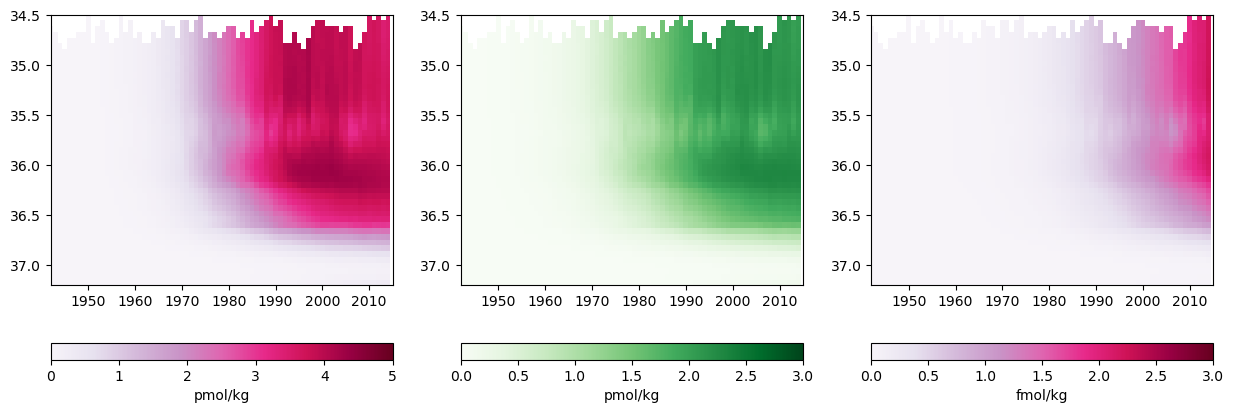

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.cfc11.T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = 5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg")

cm = ax[1].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.cfc12.T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = 3)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg")

cm = ax[2].pcolormesh(section_dsm.year, weighted_mean_ds.sigma2, weighted_mean_ds.sf6.T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = 3)
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg")


[a.set_ylim(34.5, 37.2) for a in ax]
[a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]


Text(0.5, 1.0, 'log(Thickness)')

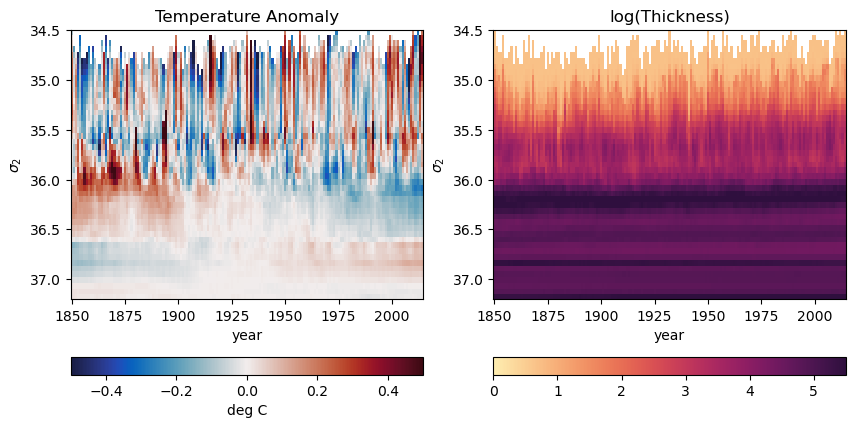

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

cm = ax[0].pcolormesh(weighted_mean_ds.year, weighted_mean_ds.sigma2, (weighted_mean_ds.thetao - weighted_mean_ds.thetao.mean("year")).T, 
               cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "deg C")
cm = ax[1].pcolormesh(weighted_mean_ds.year, weighted_mean_ds.sigma2,  np.log(weighted_mean_ds.thkcello).T, 
               cmap = cmocean.cm.matter, vmin = 0, vmax = 5.5)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "")

[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\sigma_2$")
ax[0].set_xlabel("year")
ax[1].set_xlabel("year")
ax[0].set_title("Temperature Anomaly")
ax[1].set_title("log(Thickness)")


[(1980.0, 2014.0), (1980.0, 2014.0), (1980.0, 2014.0)]

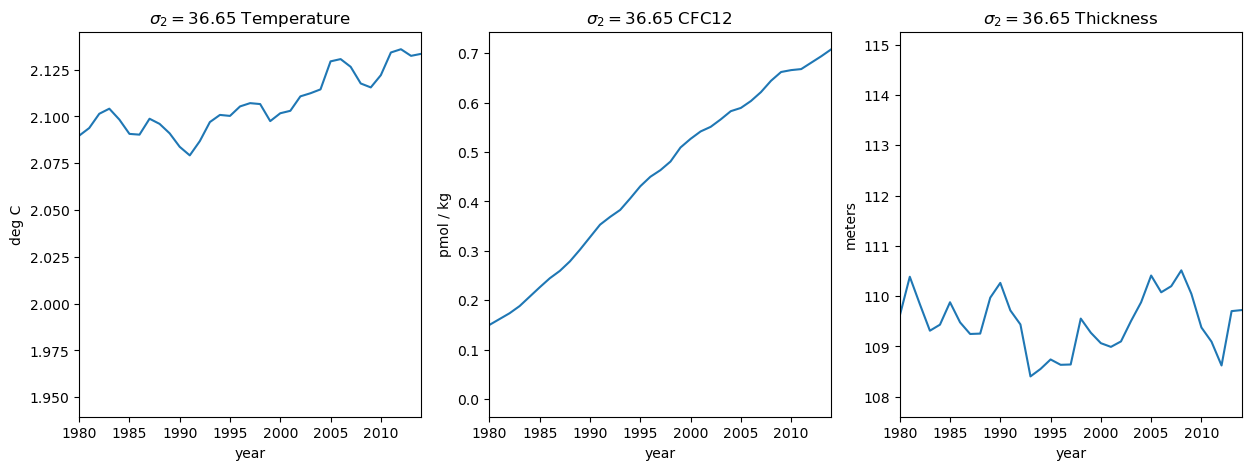

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0]); ax[0].set_title(r"$\sigma_2 = 36.65$" + " Temperature")
cfc = weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").cfc12
cfc = cfc* variable_kwargs["cfc12"]["conversion"]
cfc.plot(ax = ax[1]); ax[1].set_title(r"$\sigma_2 = 36.65$" + " CFC12 ")
weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[2]); ax[2].set_title(r"$\sigma_2 = 36.65$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg")
ax[2].set_ylabel("meters")      
[a.set_xlim(1980, 2014) for a in ax]


[(1950.0, 2014.0), (1950.0, 2014.0), (1950.0, 2014.0)]

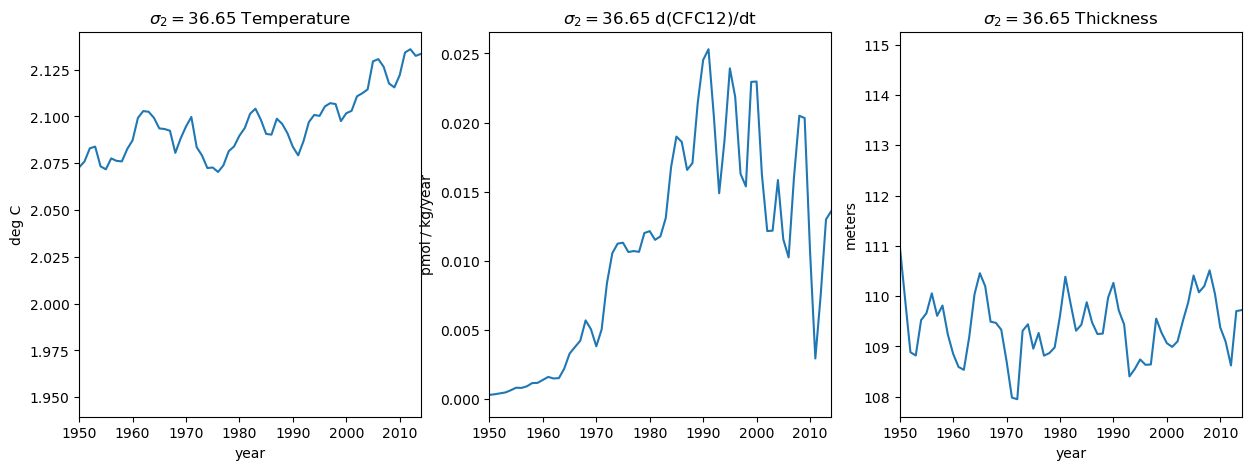

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0]); ax[0].set_title(r"$\sigma_2 = 36.65$" + " Temperature")
cfc = weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").cfc12
cfc = cfc* variable_kwargs["cfc12"]["conversion"]
ax[1].plot(section_dsm.year[2:], (cfc.values[2:] - cfc.values[:-2]) / 2)
ax[1].set_title(r"$\sigma_2 = 36.65$" + " d(CFC12)/dt ")
weighted_mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[2]); ax[2].set_title(r"$\sigma_2 = 36.65$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg/year")
ax[2].set_ylabel("meters")   
[a.set_xlim(1950, 2014) for a in ax]


In [22]:
ds = pd.read_csv(datadir('mf_CFC-11_obs.csv'), skiprows = 3)
times = ds.iloc[:, 0]
cfcs = np.float32(ds.iloc[:, 1])

In [23]:
dtimes = (times.values[1:] + times.values[:-1]) / 2

In [24]:
dt = times.values[1:] - times.values[:-1]
dcfcs = cfcs[1:] - cfcs[:-1]

In [25]:
import numpy as np
from scipy import interpolate
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [26]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Filter requirements.
order = 2
fs = 12       # sample rate, Hz
cutoff = 1/(12 * 1)  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)


(1950.0, 2014.0)

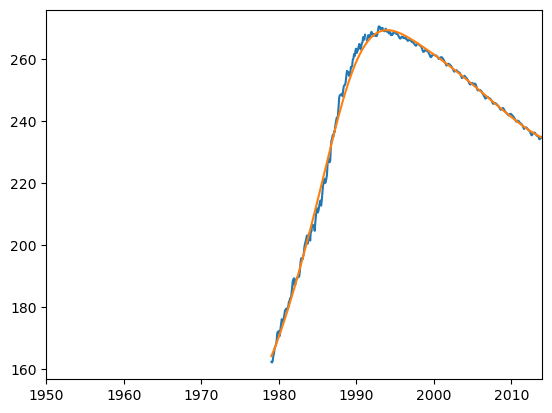

In [27]:
plt.plot(times, cfcs)
y = butter_lowpass_filter(fill_nan(cfcs)[:-7], 1/12, 12, 2)
plt.plot(times[:-7],y)
plt.xlim(1950, 2014)


(1950.0, 2014.0)

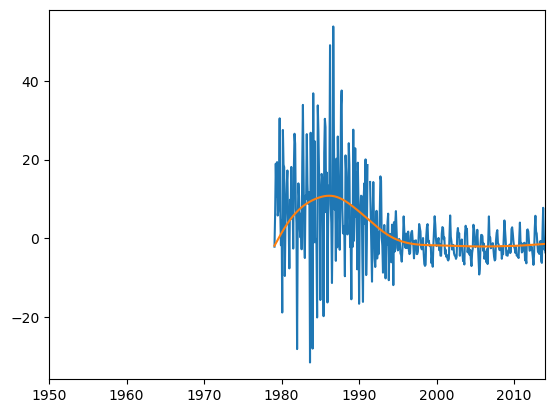

In [28]:
plt.plot(dtimes, dcfcs / dt)
y = butter_lowpass_filter(fill_nan(dcfcs / dt)[:-7], 1/12, 12, 2)
plt.plot(dtimes[:-7],y)
plt.xlim(1950, 2014)


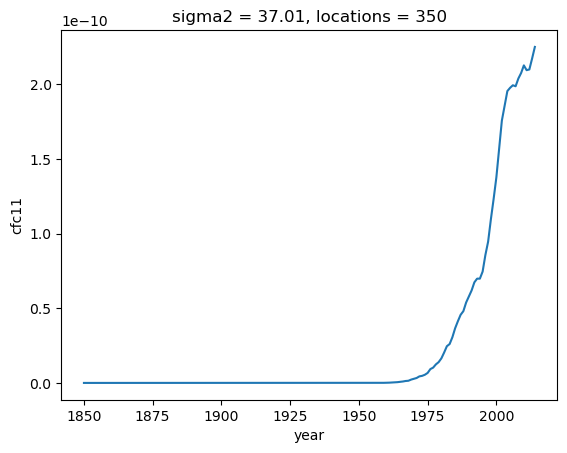

2024-04-05 23:15:29,891 - distributed.batched - INFO - Batched Comm Closed <TCP (closed)  local=tcp://172.16.3.67:39382 remote=tcp://172.16.3.67:59012>
Traceback (most recent call last):
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/comm/tcp.py", line 269, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError


In [29]:
cfc11 = ds_section.sel(sigma2 = 37., locations = 350, method = "nearest").cfc11
cfc11.plot()

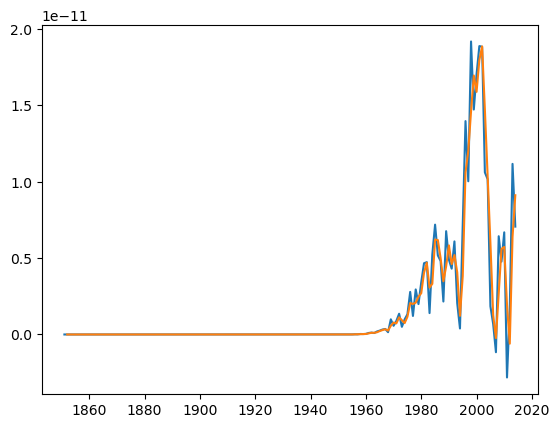

In [82]:
dcfc11 = cfc11.values[1:] - cfc11.values[:-1]
plt.plot(cfc11.year[1:], dcfc11)

dcfc11 = cfc11.values[2:] - cfc11.values[:-2]
plt.plot(cfc11.year[2:], dcfc11 / 2)